## Part I : Global includes



In [1]:

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import torch
import numpy as np
import cv2
import tensorflow as tf

# Uncomment to disable GPU usage.
# This is required for some models like Pridnet which has too many traininable parameters
tf.config.set_visible_devices([], 'GPU')

from tqdm.notebook import tqdm
import random


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Part II : Loading test images

In [12]:
#from sklearn.model_selection import train_test_split
from data_importer import load_training_images, read_image

def lung_load_training_images(low_dose_ct_training_dataset_dir='../../../Dataset/LowDoseCTGrandChallenge/Training_Image_Data', load_limited_images=False, num_images_to_load=10, reverse_order=False):
    
    training_filepaths_x = []   # i.e the QD (quarter dose) images (noisy images)
    training_filepaths_y = []   # i.e the FD (full dose) images (clean images)

    for root, folder_name, file_names in os.walk(low_dose_ct_training_dataset_dir):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
        
            if "QD" in file_name and "L291_QD_3_1.CT.0003.0088.2015.12.23.17.49.43.831724.127636753.IMA" in file_name:
                training_filepaths_x.append(file_path)
            elif "FD" in file_name and "L291_FD_3_1.CT.0005.0088.2015.12.23.17.48.23.868235.127714905.IMA" in file_name:
                training_filepaths_y.append(file_path)
            
    training_filepaths_x.sort()
    training_filepaths_y.sort()
    
    if load_limited_images:
        if not reverse_order:
            training_filepaths_x = training_filepaths_x[:num_images_to_load]
            training_filepaths_y = training_filepaths_y[:num_images_to_load]
        
        if reverse_order:
            training_filepaths_x = training_filepaths_x[-1 * num_images_to_load:]
            training_filepaths_y = training_filepaths_y[--1 * num_images_to_load:]
            
        
    training_images_x = np.array([np.expand_dims(read_image(path), axis=-1) for path in training_filepaths_x])
    training_images_y = np.array([np.expand_dims(read_image(path), axis=-1) for path in training_filepaths_y])
        
    print('loaded training images x and y of len : ', len(training_images_x), len(training_images_y), ' respectively')
    print('type of train images x : ', training_images_x[0].dtype)
    print('range of values in train images : ', np.min(training_images_x[0]), np.max(training_images_x[0]))
    print('type of train images y : ', training_images_y[0].dtype)
    
    return training_images_x, training_images_y

noisy_array, gt_array = lung_load_training_images('../../../../Dataset/LowDoseCTGrandChallenge/Training_Image_Data/', load_limited_images=True, num_images_to_load=10)
lung_noisy, lung_clean  = noisy_array, gt_array

extended_noisy_array = noisy_array
extended_gt_array = gt_array

loaded training images x and y of len :  1 1  respectively
type of train images x :  float64
range of values in train images :  -0.017142857142857144 1.5792857142857142
type of train images y :  float64


In [13]:
lung_noisy.min(), lung_noisy.max(), lung_clean.min(), lung_clean.max()

(-0.017142857142857144,
 1.5792857142857142,
 -0.017142857142857144,
 1.5771428571428572)

Visualization of the noisy / ground truth image pair

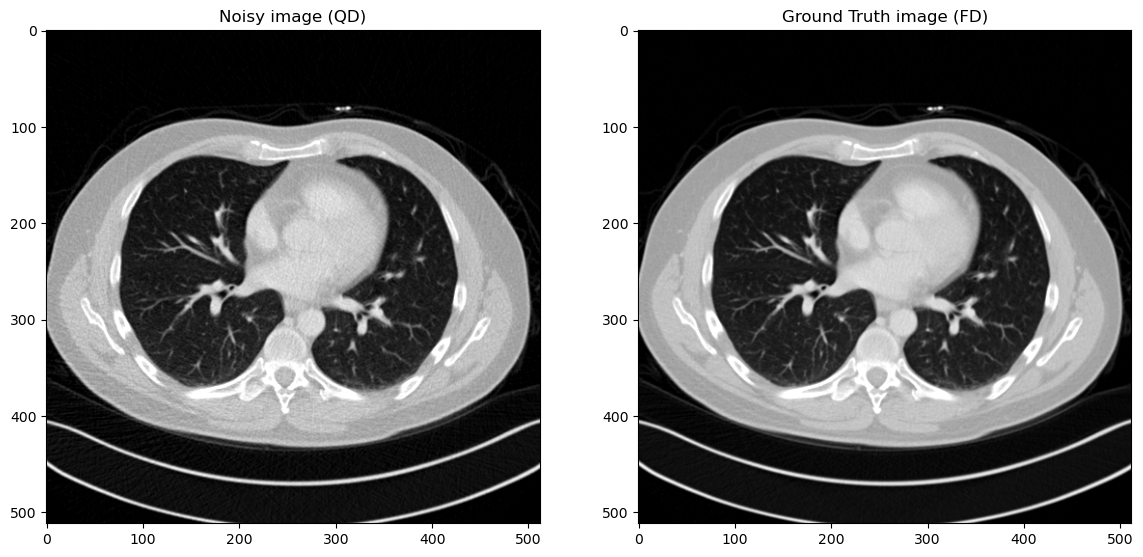

In [15]:
from data_importer import denormalize, trunc

for i in range(0,1):
    f, axarr = plt.subplots(1,2, figsize=(14,14))
    axarr[0].imshow(trunc(denormalize(noisy_array[i])), vmin=-1000.0, vmax=400.0, cmap='gray')
    axarr[0].set_title("Noisy image (QD)")
    axarr[1].imshow(trunc(denormalize(gt_array[i])), vmin=-1000.0, vmax=400.0, cmap='gray')
    axarr[1].title.set_text("Ground Truth image (FD)")
    plt.show()

### Part III : Setup for Inference

In [16]:
# Inference
def inference_single_image(model, noisy_image):
    input_image = np.expand_dims(noisy_image, axis=0)
    predicted_image = model.predict(input_image)
    a = np.abs(np.min(predicted_image))
    b = np.max(predicted_image)
    
    #predicted_image = predicted_image * (b - a) + a
    return predicted_image[0]

def inference_batch_images(model, noisy_images):
    input_image = noisy_images

    predicted_image = model.predict(input_image).astype(np.float64)
    return predicted_image

In [17]:
def rgb2gray(rgb):
    return np.expand_dims(np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]), axis=-1)

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio
import sys
sys.path.append('../')

from metrics import compute_SSIM, compute_PSNR
from skimage.metrics import mean_squared_error  as mse

def calculate_psnr(original_image, reconstructed_image,range=1400):
    return peak_signal_noise_ratio(original_image, reconstructed_image,data_range=range) 

    psnr_value = peak_signal_noise_ratio(original_image, reconstructed_image, data_range=240+160)
    return psnr_value

def calculate_ssim(original_image, reconstructed_image, range=1400):    
    ssim_value = ssim(original_image.astype(np.int16), reconstructed_image.astype(np.int16), win_size=11, channel_axis=2, data_range=range)
    return ssim_value

def calculate_rmse(original_image, reconstructed_image):
    return mse(original_image, reconstructed_image)

def visualize_predictions(model, X_test, y_test, n, predictions, model_name):
    random_numbers = list(range(n)) # not very random
    for i in random_numbers:
        noisy_image = X_test[i].astype(np.float16)
        gt_image = y_test[i].astype(np.float16)
        predicted_image = predictions[i].astype(np.float16)

        if predicted_image.shape[-1] == 3:
            predicted_image = rgb2gray(predicted_image)
                                
            
        psnr_recon =  calculate_psnr(trunc(denormalize(gt_image)), trunc(denormalize(predicted_image)))
        psnr_qd =  calculate_psnr(trunc(denormalize(gt_image)),  trunc(denormalize(noisy_image)))
        ssim_recon = calculate_ssim(trunc(denormalize(gt_image)),  trunc(denormalize(predicted_image)))
        ssim_qd =calculate_ssim(trunc(denormalize(gt_image)), trunc(denormalize(noisy_image)))
        rmse_recon = calculate_rmse(trunc(denormalize(gt_image)),  trunc(denormalize(predicted_image)))
        rmse_qd=calculate_rmse(trunc(denormalize(gt_image)), trunc(denormalize(noisy_image)))
        
        psnr_recon = round(psnr_recon, 4)
        psnr_qd = round(psnr_qd, 4)
        ssim_recon = round(ssim_recon, 4)
        ssim_qd = round(ssim_qd, 4)
        rmse_recon = round(rmse_recon, 4)
        rmse_qd = round(rmse_qd, 4)
        
        f, axarr = plt.subplots(1,3, figsize=(21,21))

        axarr[0].imshow(trunc(denormalize(noisy_image)), cmap='gray', vmin=-1000, vmax=400.0)
        axarr[0].set_title("QD Image : PSNR={}\nSSIM={}\nRMSE={}".format(psnr_qd, ssim_qd, rmse_qd))
        axarr[0].set_axis_off()
        axarr[1].imshow(trunc(denormalize(gt_image)),  cmap='gray', vmin=-1000, vmax=400.0)
        axarr[1].set_title("FD Image")
        axarr[1].set_axis_off()
        axarr[2].imshow(trunc(denormalize(predicted_image)), cmap='gray', vmin=-1000, vmax=400.0)
        axarr[2].set_title("{} Predicted Image : PSNR={}\nSSIM={}\nRMSE={}".format(model_name, psnr_recon, ssim_recon, rmse_recon))
        axarr[2].set_axis_off()
        
        plt.show()

In [18]:
from skimage.metrics import peak_signal_noise_ratio

def get_average_metrics(predicted_images, _gt_array, _noisy_array):
    psnr_original_mean = 0
    psnr_prediction_mean = 0

    ssim_original_mean = 0
    ssim_prediction_mean = 0

    mse_original_mean = 0
    mse_prediction_mean = 0

    if np.all(_gt_array) != None:
        gt_array = _gt_array
        noisy_array = _noisy_array
        

    i = 0
    for gt_img, noisy_img, predicted_img in zip(gt_array, noisy_array, predicted_images):
        predicted_img=  predicted_images[i]
        if predicted_img.shape[-1] == 3:
            predicted_img = rgb2gray(predicted_img)
            
        psnr_recon =  calculate_psnr(trunc(denormalize(gt_img)), trunc(denormalize(predicted_img)))
        psnr_qd =  calculate_psnr(trunc(denormalize(gt_img)),  trunc(denormalize(noisy_img)))
        ssim_recon = calculate_ssim(trunc(denormalize(gt_img)),  trunc(denormalize(predicted_img)))
        ssim_qd =calculate_ssim(trunc(denormalize(gt_img)), trunc(denormalize(noisy_img)))
        rmse_recon = calculate_rmse(trunc(denormalize(gt_img)),  trunc(denormalize(predicted_img)))
        rmse_qd=calculate_rmse(trunc(denormalize(gt_img)), trunc(denormalize(noisy_img)))

        psnr_original_mean += psnr_qd
        psnr_prediction_mean += psnr_recon
        
        ssim_original_mean += ssim_qd
        ssim_prediction_mean += ssim_recon

        mse_original_mean += rmse_qd
        mse_prediction_mean += rmse_recon
        
        i = i + 1        
    
    psnr_original_mean/=gt_array.shape[0]
    psnr_prediction_mean/=gt_array.shape[0]

    ssim_original_mean/=gt_array.shape[0]
    ssim_prediction_mean/=gt_array.shape[0]

    mse_original_mean/=gt_array.shape[0]
    mse_prediction_mean/=gt_array.shape[0]
    
    print("Original average gt-noisy PSNR ->", psnr_original_mean)
    print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

    print("Original average gt-noisy SSIM ->", ssim_original_mean)
    print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

    print("Original average gt-noisy MSE->", mse_original_mean)
    print("Predicted average gt-predicted MSE->", mse_prediction_mean)
    
    return round(psnr_prediction_mean, 4), round(ssim_prediction_mean, 4), round(mse_prediction_mean, 4), round(psnr_prediction_mean - psnr_original_mean, 4), round(ssim_prediction_mean - ssim_original_mean, 4), round(mse_prediction_mean - mse_original_mean, 4)


## Part IV : Evaluation of each model

## Model 1 : Hformer (for base reference)

In [22]:
sys.path.append('../denoising-models/hformer_pytorch/')

from hformer_model import HformerModel

model = HformerModel(num_channels=64).cuda()
model.load_state_dict(torch.load('../denoising-models/hformer_pytorch/weights/model_78.pth'))
model.eval()

HformerModel(
  (ip): InputProjectionLayer(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (op): OutputProjectionLayer(
    (conv2d_transpose): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv_block_1): ConvBlock(
    (zero_padding): ZeroPad2d((3, 3, 3, 3))
    (dwconv): DepthWiseSeparableConv2d(
      (depthwise): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=64, bias=False)
      (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (layer_norm): LayerNorm((64, 64, 70, 70), eps=1e-05, elementwise_affine=False)
    (linear_1): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1))
    (gelu): GELU(approximate='none')
    (linear_2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv_block_2): ConvBlock(
    (zero_padding): ZeroPad2d((3, 3, 3, 3))
    (dwconv): DepthWiseSeparableConv2d(
      (depthwise): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), 

In [23]:
def reconstruct_image_from_patches(patches, num_patches_per_row):
    patch_size = patches.shape[1]  # Assuming square patches
    num_patches = patches.shape[0]

    # Calculate the number of rows
    num_patches_per_col = num_patches // num_patches_per_row

    # Initialize an empty image to store the reconstructed result
    reconstructed_image = np.zeros((num_patches_per_col * patch_size, num_patches_per_row * patch_size))

    # Reshape the patches into a 2D array
    patches_2d = patches.reshape((num_patches_per_col, num_patches_per_row, patch_size, patch_size))
    # Reconstruct the image by placing each patch in its corresponding position

    for i in range(num_patches_per_col):
        for j in range(num_patches_per_row):
            reconstructed_image[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = patches_2d[i, j]

    return np.expand_dims(reconstructed_image, axis=-1)

In [24]:
# View the predictions
from data_importer import denormalize, trunc
def patch_extractor(image, patch_width=64, patch_height=64):
    image = image.copy()
    print(image.shape) 
    num_images, image_height, image_width, channels = image.shape
    patches = image.reshape(-1, image_height // patch_height, patch_height, image_width // patch_width, patch_width, channels)
    patches = patches.swapaxes(2, 3)
    patches = patches.reshape(-1, patch_height, patch_width, channels)
    
    return torch.from_numpy(patches)
noisy_image_patches_array = patch_extractor(noisy_array)
extended_noisy_image_patches_array = patch_extractor(extended_noisy_array)

(1, 512, 512, 1)
(1, 512, 512, 1)


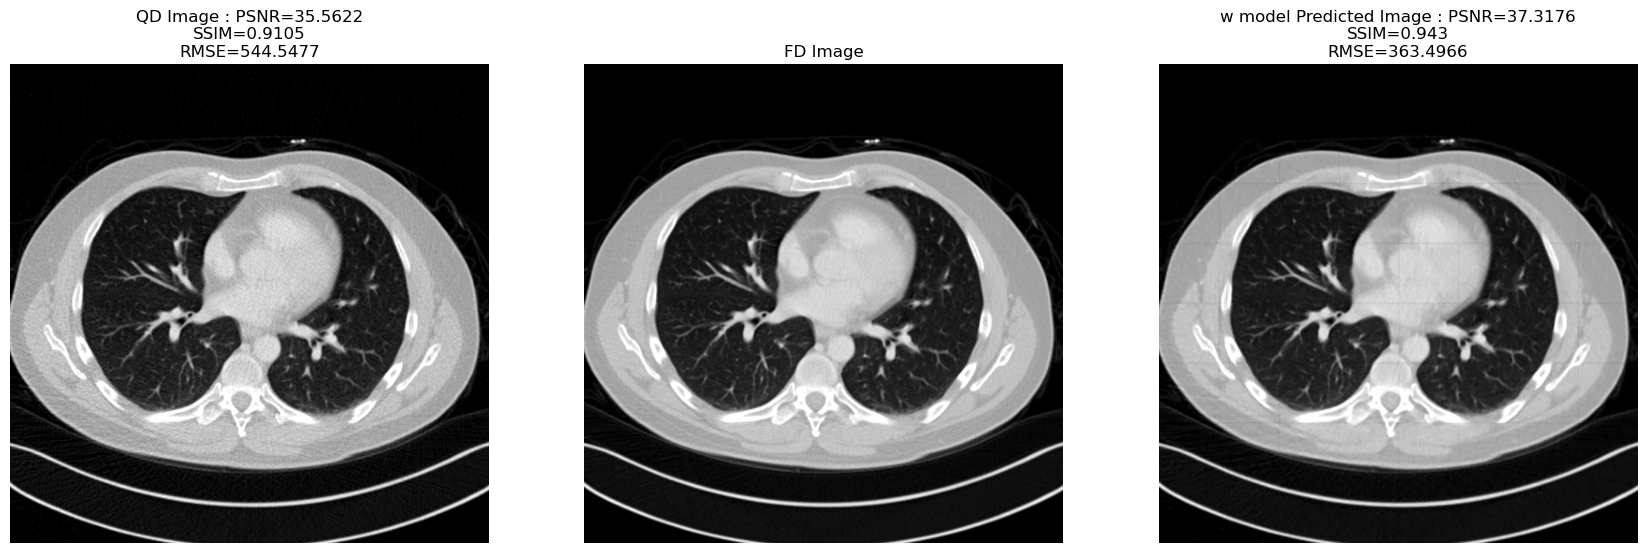

In [35]:
hformer_prediction_patches = []

with torch.no_grad():    
    for i in range(0, 1):
        noisy = noisy_image_patches_array
    
        predictions = model(torch.from_numpy(noisy.numpy()).float().to('cuda')).cpu()

        hformer_prediction_patches.append(predictions.detach().cpu())
    
hformer_prediction_patches= np.concatenate(hformer_prediction_patches, axis=0)

hformer_prediction= np.expand_dims(reconstruct_image_from_patches(hformer_prediction_patches[0:64], 8), axis=0)


for i in range(1, int(hformer_prediction_patches.shape[0] / 64)): 
    reconstructed_image = reconstruct_image_from_patches(hformer_prediction_patches[i * 64 : i * 64 + 64], num_patches_per_row=8)
    reconstructed_image = np.expand_dims(reconstructed_image, axis=0)

    hformer_prediction= np.append(hformer_prediction, reconstructed_image, axis=0)

visualize_predictions(model, noisy_array, gt_array, len(gt_array), hformer_prediction, "w model")

# Model 2 : W Model

In [36]:

sys.path.append('../denoising-models/hformer_pytorch')
from torchinfo import summary

from w_model import WModel 

w_model = WModel(num_channels=32).cuda()
w_model.load_state_dict(torch.load('../denoising-models/hformer_pytorch/weights/model_278.pth'))
w_model.eval()
print('model summary\n', summary(w_model, input_size=(64, 64, 64, 1)))

Using cache found in C:\Users\Tarun/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
Using cache found in C:\Users\Tarun/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


model summary
Layer (type:depth-idx)                   Output Shape              Param #
WModel                                   [64, 64, 64, 1]           --
├─InputProjectionLayer: 1-1              [64, 32, 64, 64]          --
│    └─Conv2d: 2-1                       [64, 32, 64, 64]          320
├─UNet: 1-2                              [64, 32, 64, 64]          --
│    └─Sequential: 2-2                   [64, 32, 64, 64]          --
│    │    └─Conv2d: 3-1                  [64, 32, 64, 64]          9,216
│    │    └─BatchNorm2d: 3-2             [64, 32, 64, 64]          64
│    │    └─ReLU: 3-3                    [64, 32, 64, 64]          --
│    │    └─Conv2d: 3-4                  [64, 32, 64, 64]          9,216
│    │    └─BatchNorm2d: 3-5             [64, 32, 64, 64]          64
│    │    └─ReLU: 3-6                    [64, 32, 64, 64]          --
│    └─MaxPool2d: 2-3                    [64, 32, 32, 32]          --
│    └─Sequential: 2-4                   [64, 64, 32, 32]       

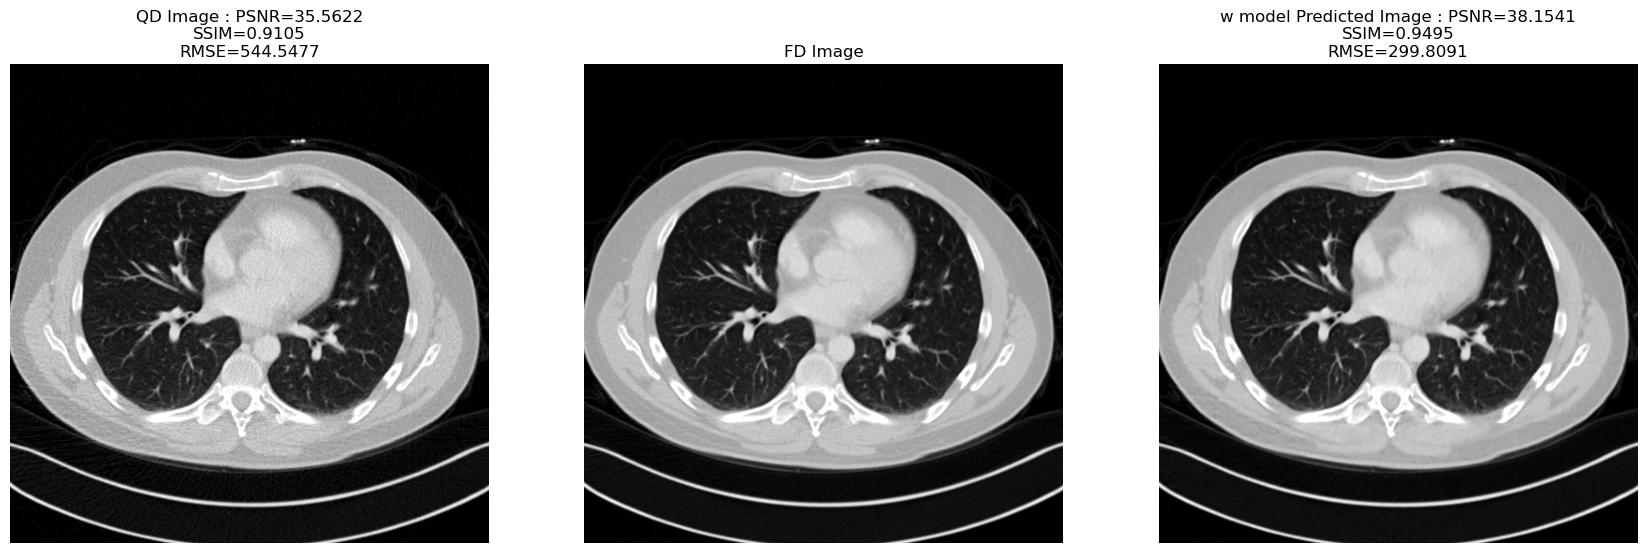

In [39]:

w_prediction_patches = []

with torch.no_grad():    
    for i, data in enumerate(noisy_image_patches_array):
        noisy = data
    
        predictions = w_model(torch.unsqueeze(torch.from_numpy(noisy.numpy()), dim=0).float().to('cuda')).cpu()

        w_prediction_patches.append(predictions.detach().cpu())
    
w_prediction_patches = np.concatenate(w_prediction_patches, axis=0)

w_predictions = np.expand_dims(reconstruct_image_from_patches(w_prediction_patches[0:64], 8), axis=0)


for i in range(1, int(w_prediction_patches.shape[0] / 64)): 
    reconstructed_image = reconstruct_image_from_patches(w_prediction_patches[i * 64 : i * 64 + 64], num_patches_per_row=8)
    reconstructed_image = np.expand_dims(reconstructed_image, axis=0)

    w_predictions= np.append(w_predictions, reconstructed_image, axis=0)

visualize_predictions(w_model, noisy_array, gt_array, len(gt_array), w_predictions, "w model")


# Model 3 : W + wavelet

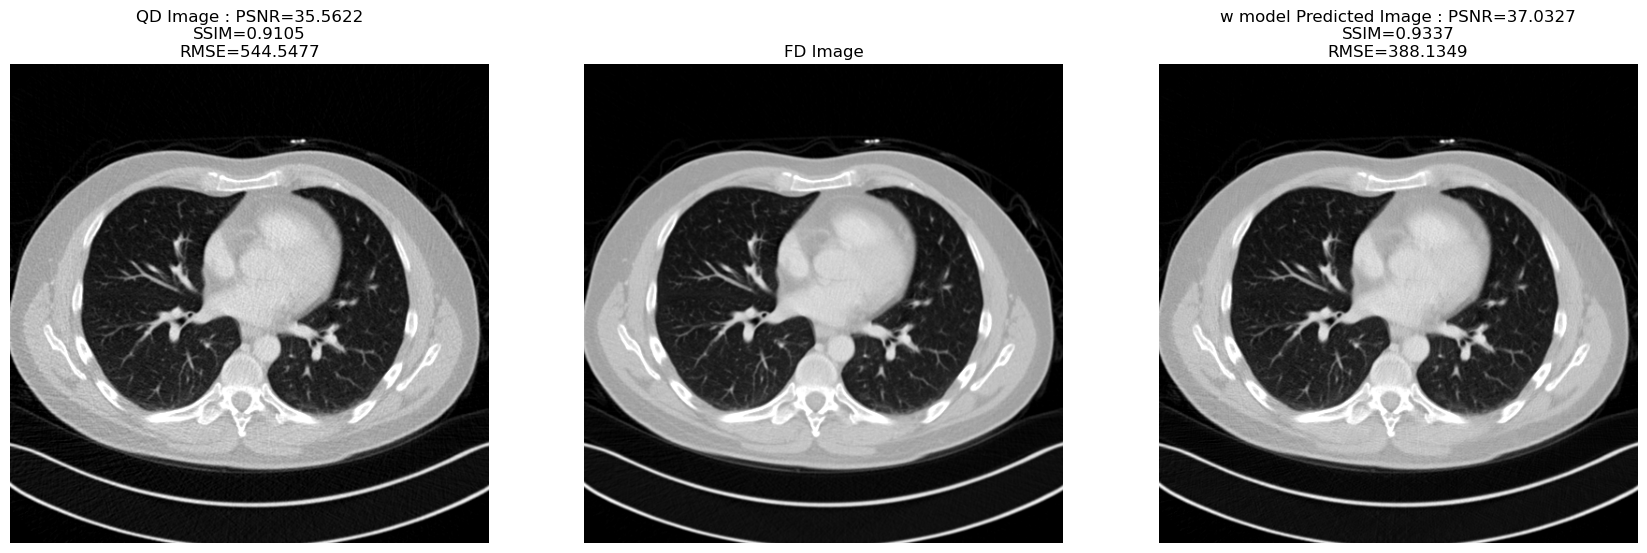

In [40]:

# W model with wavelet
from pytorch_wavelets import DTCWTForward, DTCWTInverse
dwt = DTCWTForward(J=3).cuda()
idwt = DTCWTInverse().cuda()
wavelet_w_model_prediction_patches =[]


with torch.no_grad():
    for i in range(extended_noisy_image_patches_array.shape[0] // 64):
        noisy = extended_noisy_image_patches_array[i * 64 : i * 64 + 64]
        noisy = torch.from_numpy(noisy.cpu().numpy()).float().to('cuda')
        prediction = w_model(noisy)

        prediction_img = torch.transpose(prediction, 1, 3)

        transposed_noisy_image = torch.transpose(noisy, 1, 3)

        prediction_approx, prediction_high_freq = dwt(prediction_img.cuda())
        prediction_high_freq_low, prediction_high_freq_mid, prediction_high_freq_coarse = prediction_high_freq[0], prediction_high_freq[1], prediction_high_freq[2]

        noisy_approx, noisy_high_freq = dwt(transposed_noisy_image.cuda())

        noisy_high_freq_fine, noisy_high_freq_mid, noisy_high_freq_coarse = noisy_high_freq[0], noisy_high_freq[1] , noisy_high_freq[2]

        reconstructed_prediction_image_with_high_freq_swap = idwt((noisy_approx, noisy_high_freq))
        reconstructed_prediction_image_with_high_freq_swap = torch.transpose(reconstructed_prediction_image_with_high_freq_swap, 3, 1)


        #denoise_high_freq = torch.transpose(torch.from_numpy(denoised_high_freq), 1, 3)
        #denoised_noisy_approx, denoised_high_freq = dwt(denoise_high_freq.cuda())
        #noisy_high_freq_fine, noisy_high_freq_mid, noisy_high_freq_coarse = denoised_high_freq[0], denoised_high_freq[1] , denoised_high_freq[2]

        wavelet_high_freq_swapped = [None] * 3
        wavelet_high_freq_swapped[0] =noisy_high_freq_fine
        wavelet_high_freq_swapped[1] =prediction_high_freq_mid
        wavelet_high_freq_swapped[2] =prediction_high_freq_coarse

        reconstructed_prediction_image = idwt((prediction_approx,wavelet_high_freq_swapped))
        reconstructed_prediction_image = torch.transpose(reconstructed_prediction_image, 1, 3)
        wavelet_w_model_prediction_patches.append(reconstructed_prediction_image.detach().cpu().numpy())

wavelet_w_predictions = [None] * extended_noisy_array.shape[0]
def reconstruct(patches,  num_images):
    num_patches_per_image = patches.shape[0] // num_images
    for i in range(num_images):
        
        image_patches = patches[i * num_patches_per_image:i * num_patches_per_image + num_patches_per_image]
        
        reconstruct_image = (reconstruct_image_from_patches(image_patches, 8))
        wavelet_w_predictions[i]  = reconstruct_image
wavelet_w_model_prediction_patches = np.concatenate(wavelet_w_model_prediction_patches)
reconstruct(wavelet_w_model_prediction_patches, extended_gt_array.shape[0])
visualize_predictions(w_model, noisy_array, gt_array, len(gt_array), wavelet_w_predictions, "w model")


# Model 4 : Wavelet EMD

In [41]:

extended_w_predictions = w_predictions.copy()

from pyemd.EMD2d import EMD2D
emd2d = EMD2D()
emd_extended_w_predictions = [None] * extended_w_predictions.shape[0]
for i in range(extended_w_predictions.shape[0]):

    noisy_reshaped = np.squeeze(extended_noisy_array[i], -1)
    print(noisy_reshaped.shape)
    noisy_imfs = emd2d.emd(noisy_reshaped,max_imf=-1)

    pred_reshaped = extended_w_predictions[i]
    pred_reshaped = np.squeeze(pred_reshaped, axis=-1)
    pred_imfs = emd2d.emd(pred_reshaped, max_imf=-1)

    __ssim = 0
    best_performing_lerp_image = None

    for y in range(1, 100):
        x = y / 100.0
        swaped_IMFs = np.array([noisy_imfs[1] * x + pred_imfs[1] * (1.0 - x), pred_imfs[0] * (1.0 - x) + noisy_imfs[0] * x])
        predictions = torch.from_numpy(np.expand_dims(np.expand_dims(np.sum(swaped_IMFs, axis=0), -1), 0))

        _ssim = calculate_ssim(trunc(denormalize(extended_gt_array[i])), trunc(denormalize(np.squeeze(predictions.detach().cpu().numpy(), axis=0))))

        if _ssim > __ssim:
            __ssim = _ssim
            best_performing_lerp_image = predictions

    emd_extended_w_predictions[i] = best_performing_lerp_image



(512, 512)


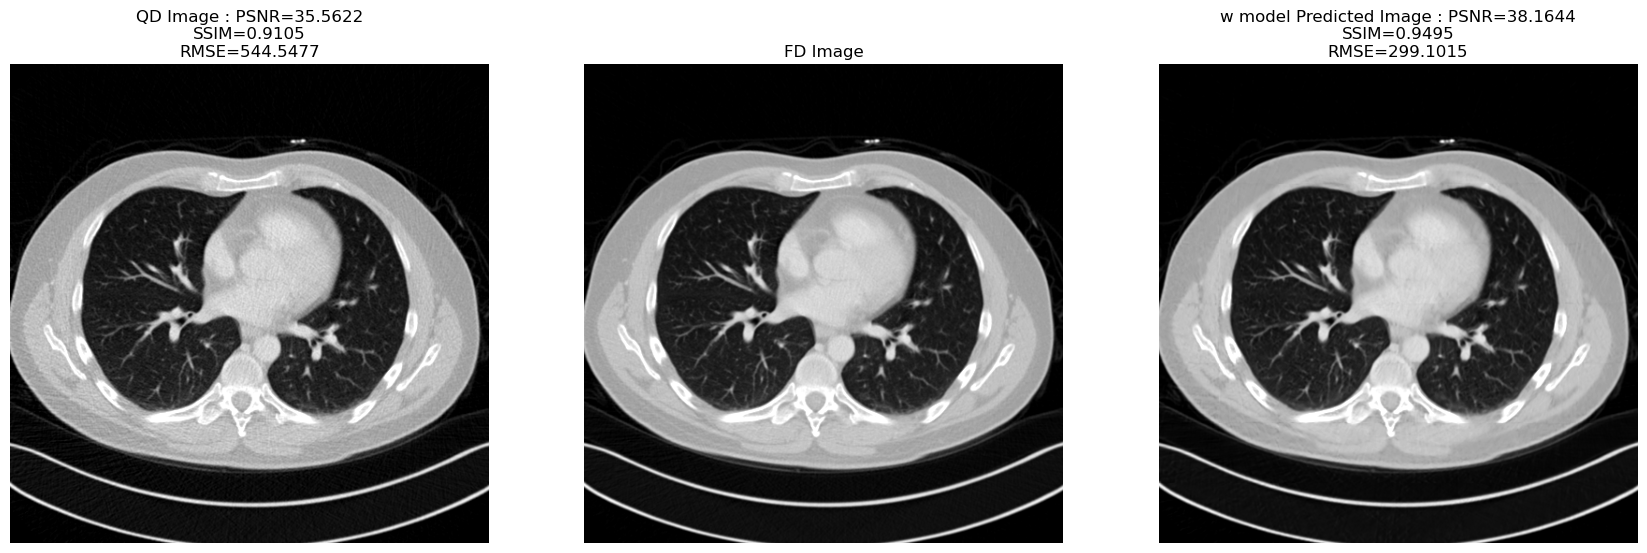

In [42]:

emd = emd_extended_w_predictions.copy()
for i, e in enumerate(emd):
    emd[i] = np.squeeze(e.detach().cpu().numpy(), axis=0)
visualize_predictions(w_model, noisy_array, gt_array, len(gt_array), emd, "w model")

## Part V : Side by side comparison of all models

In [43]:
from prettytable import PrettyTable

pt = PrettyTable()
pt.field_names = ["Model", "PSNR", "SSIM", "MSE", "PSNR Improvement", "SSIM improvement", "MSE Improvement"]

hformer_metrics = get_average_metrics(hformer_prediction, gt_array, noisy_array)
w_metrics = get_average_metrics(w_predictions, gt_array, noisy_array)
w_wavelet_metrics = get_average_metrics(wavelet_w_predictions, gt_array, noisy_array)
w_emd_metrics = get_average_metrics(emd, gt_array, noisy_array)





Original average gt-noisy PSNR -> 35.56213469262881
Predicted average gt-predicted PSNR -> 37.317635830837254
Original average gt-noisy SSIM -> 0.9104580115686829
Predicted average gt-predicted SSIM -> 0.9430949717383029
Original average gt-noisy MSE-> 544.5560684204102
Predicted average gt-predicted MSE-> 363.49001742617514
Original average gt-noisy PSNR -> 35.56213469262881
Predicted average gt-predicted PSNR -> 38.155002422222765
Original average gt-noisy SSIM -> 0.9104580115686829
Predicted average gt-predicted SSIM -> 0.9495386075210405
Original average gt-noisy MSE-> 544.5560684204102
Predicted average gt-predicted MSE-> 299.747679117542
Original average gt-noisy PSNR -> 35.56213469262881
Predicted average gt-predicted PSNR -> 37.03339257643508
Original average gt-noisy SSIM -> 0.9104580115686829
Predicted average gt-predicted SSIM -> 0.933788253968299
Original average gt-noisy MSE-> 544.5560684204102
Predicted average gt-predicted MSE-> 388.0760254292421
Original average gt-nois

In [44]:

pt.add_row(["Original X-y pairs (No Model)","21.97","0.78911", '-', '-', "-", "-"])
pt.add_row(["Hformer",str(hformer_metrics[0]), str(hformer_metrics[1]), str(round(hformer_metrics[2], 4)), str(round(hformer_metrics[3], 4)), str(round(hformer_metrics[4] * 100, 4)), str(hformer_metrics[5]) + '%'])
pt.add_row(["W Model",str(w_metrics[0]), str(w_metrics[1]), str(round(w_metrics[2], 4)), str(round(w_metrics[3], 4)), str(round(w_metrics[4] * 100, 4)), str(w_metrics[5]) + '%'])
pt.add_row(["W + Wavelet Model",str(w_wavelet_metrics[0]), str(w_wavelet_metrics[1]), str(round(w_wavelet_metrics[2], 4)), str(round(w_wavelet_metrics[3], 4)), str(round(w_wavelet_metrics[4] * 100, 4)), str(w_wavelet_metrics[5]) + '%'])
pt.add_row(["W + emd Model",str(w_emd_metrics[0]), str(w_emd_metrics[1]), str(round(w_emd_metrics[2], 4)), str(round(w_emd_metrics[3], 4)), str(round(w_emd_metrics[4] * 100, 4)), str(w_emd_metrics[5]) + '%'])

print(pt)

+-------------------------------+---------+---------+----------+------------------+------------------+-----------------+
|             Model             |   PSNR  |   SSIM  |   MSE    | PSNR Improvement | SSIM improvement | MSE Improvement |
+-------------------------------+---------+---------+----------+------------------+------------------+-----------------+
| Original X-y pairs (No Model) |  21.97  | 0.78911 |    -     |        -         |        -         |        -        |
|            Hformer            | 37.3176 |  0.9431 |  363.49  |      1.7555      |       3.26       |    -181.0661%   |
|            W Model            |  38.155 |  0.9495 | 299.7477 |      2.5929      |       3.91       |    -244.8084%   |
|       W + Wavelet Model       | 37.0334 |  0.9338 | 388.076  |      1.4713      |       2.33       |     -156.48%    |
|         W + emd Model         | 38.1648 |  0.9496 | 299.0729 |      2.6027      |       3.91       |    -245.4832%   |
+-------------------------------

## Part 6 : Output of predictions of all 4 models side by side for direct visualize comparison

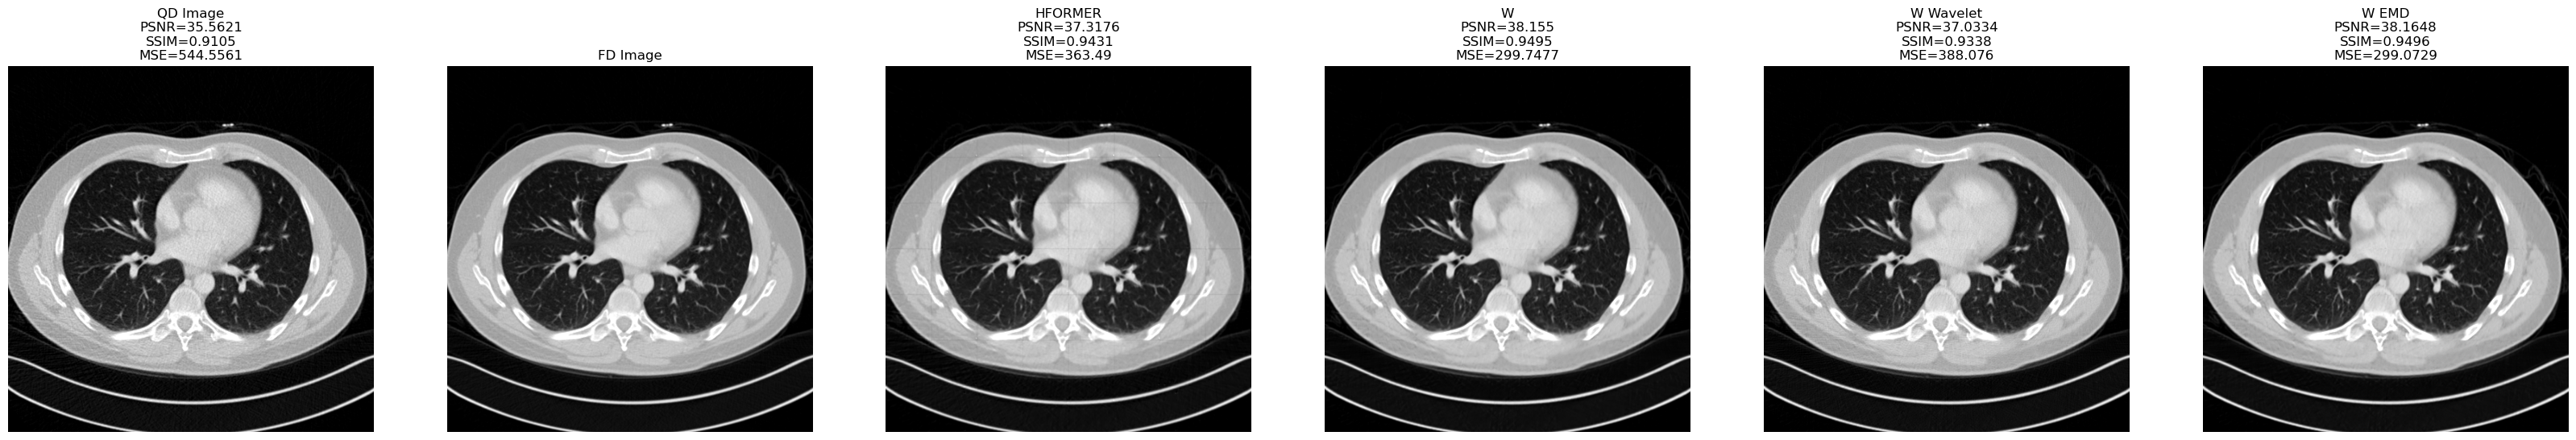

In [45]:
def visualize_predictions_all_models(X_test, y_test, n, hformer_predictions, w_predictions, w_wavelet, w_emd):
    random_numbers = list(range(n))  # not very random
    for i in random_numbers:
        noisy_image = X_test[i]
        gt_image = y_test[i]

        hformer_pred = hformer_predictions[i]
        w_pred = w_predictions[i]
        w_wavelet_pred = w_wavelet[i]
        w_emd_pred = w_emd[i]

        models = ["HFORMER", "W", "W Wavelet", "W EMD"]
        predictions = [hformer_pred,  w_pred, w_wavelet_pred, w_emd_pred]

        # Display QD and FD images
        f, axarr = plt.subplots(1, 2 + len(models), figsize=(41,41))

        psnr_qd =  calculate_psnr(trunc(denormalize(gt_image)),  trunc(denormalize(noisy_image)))
        ssim_qd =calculate_ssim(trunc(denormalize(gt_image)), trunc(denormalize(noisy_image)))
        rmse_qd = calculate_rmse(trunc(denormalize(gt_image)), trunc(denormalize(noisy_image)))

        axarr[0].imshow(trunc(denormalize(noisy_image)), cmap='gray', vmin=-1000.0, vmax=400.0)
        axarr[0].set_title("QD Image\nPSNR={}\nSSIM={}\nMSE={}".format(round(psnr_qd, 4), round(ssim_qd, 4), round(rmse_qd, 4)))

        axarr[0].set_axis_off()
        axarr[1].imshow(trunc(denormalize(gt_image)), cmap='gray', vmin=-1000.0, vmax=400.0)
        axarr[1].set_title("FD Image")
        axarr[1].set_axis_off()

        for j, (model_name, predicted_image) in enumerate(zip(models, predictions), start=2):
            if predicted_image.shape[-1] == 3:
                predicted_image = rgb2gray(predicted_image)

            psnr_recon = calculate_psnr(trunc(denormalize(gt_image)), trunc(denormalize(predicted_image)))
            ssim_recon = calculate_ssim(trunc(denormalize(gt_image)), trunc(denormalize(predicted_image)))
            rmse_recon = calculate_rmse(trunc(denormalize(gt_image)), trunc(denormalize(predicted_image)))

            psnr_recon = round(psnr_recon, 4)
            ssim_recon = round(ssim_recon, 4)
            mse_recon = round(rmse_recon, 4)

            axarr[j].imshow(trunc(denormalize(predicted_image)), cmap='gray', vmin=-1000.0, vmax=400.0)
            axarr[j].set_title("{}\nPSNR={}\nSSIM={}\nMSE={}".format(model_name, psnr_recon, ssim_recon, mse_recon))
            axarr[j].set_axis_off()

        plt.savefig('../../output/lung_novel_comparison/combined_outputs_image_index_{}.png'.format(i))
        plt.show()

visualize_predictions_all_models(noisy_array, gt_array, len(gt_array), hformer_prediction,  w_predictions, wavelet_w_predictions, emd)

In [46]:
def visualize_predictions_all_models(X_test, y_test, n, hformer_predictions, w_predictions, w_wavelet, w_emd):
    random_numbers = list(range(n))  # not very random
    for i in random_numbers:
        noisy_image = X_test[i]
        gt_image = y_test[i]

        hformer_pred = hformer_predictions[i]
        w_pred = w_predictions[i]
        w_wavelet_pred = w_wavelet[i]
        w_emd_pred = w_emd[i]

        models = ["HFORMER", "W", "W Wavelet", "W EMD"]
        predictions = [hformer_pred,  w_pred, w_wavelet_pred, w_emd_pred]

        # Display QD and FD images
        f, axarr = plt.subplots(1, 2 + len(models), figsize=(400,400))

        psnr_qd =  calculate_psnr(trunc(denormalize(gt_image)),  trunc(denormalize(noisy_image)))
        ssim_qd =calculate_ssim(trunc(denormalize(gt_image)), trunc(denormalize(noisy_image)))
        rmse_qd = calculate_rmse(trunc(denormalize(gt_image)), trunc(denormalize(noisy_image)))

        axarr[0].imshow(trunc(denormalize(noisy_image)), cmap='gray', vmin=-1000, vmax=400.0)
        axarr[0].set_title("QD Image")
        axarr[0].set_axis_off()

        axarr[1].imshow(trunc(denormalize(gt_image)), cmap='gray', vmin=-1000.0, vmax=400.0)
        axarr[1].set_title("FD Image")
        axarr[1].set_axis_off()

        for j, (model_name, predicted_image) in enumerate(zip(models, predictions), start=2):
            if predicted_image.shape[-1] == 3:
                predicted_image = rgb2gray(predicted_image)

            axarr[j].imshow(trunc(denormalize(predicted_image)), cmap='gray', vmin=-1000.0, vmax=400.0)
            axarr[j].set_title(f"{model_name}")
            axarr[j].set_axis_off()

            # Save each axarr into a separate image
            plt.gcf().set_size_inches(30, 30)
            plt.savefig('../../output/lung_novel_comparison/no_metrics_combined_outputs_image_index_{}_{}.png'.format(model_name.lower(), i), dpi=1000, bbox_inches="tight")
            plt.close()

        # Uncomment the following line if you want to show each image as well
        plt.show()

visualize_predictions_all_models(noisy_array, gt_array, 1, hformer_prediction,  w_predictions, wavelet_w_predictions, emd)
